In [1]:
from pathlib import Path
from unittest import case

import torch

data_dir: Path = Path('..').resolve() / 'data'
survey_results: Path = data_dir / 'bass_bot_survey_responses.csv'
assert survey_results.exists(), f'Do you have the Survey Responses in the correct location ({survey_results})?'

survey_results.exists(), survey_results

(True,
 PosixPath('/home/duke_trystan/PycharmProjects/Bass-Bot/data/bass_bot_survey_responses.csv'))

In [2]:
import pandas as pd

df: pd.DataFrame = pd.read_csv(survey_results)
df

,Timestamp,Prompt: Sadness defined in chiptune,Prompt: Give me the opposite of sexy music. Preferably include a sitar and a tuba.,"Prompt: Make bassline for a crying GPU struggling to meet the demands of the masses, crying out to its father one last time.",Prompt: A jazz standard with a synth pad going hard.,Prompt: An epic clash of sword against sword - or guitar against drums rather.,How likely are you to recommend Bass Bot to a friend?,Did you prompt Bass Bot directly in a discord server?,I enjoyed the songs Bass Bot generated,The songs Bass Bot generated reflected my prompt well,...,Bass Bot kept me informed of the progress of my request.,Prompting Bass Bot was convenient.,I needed support or documentation to use Bass Bot.,I found Boss Bot to be unnecessarily complex.,I feel confident using Bass Bot.,Bass Bot did what I expected it to do.,I had to learn a lot of things before I could use Bass Bot effectively.,My interactions with Bass Bot were smooth and intuitive.,The music generation process felt too long or confusing.,I would like to continue using Bass Bot regularly.
0,5/3/2025 18:26:31,I liked two more.,I didn't like either samples.,I liked two more.,I liked two more.,I liked both samples equally.,8,Yes,5,2,...,3,5,3,3,3,3,3,3,3,3
1,5/3/2025 18:26:48,I liked one more.,I liked two more.,I liked two more.,I liked two more.,I liked two more.,1,Yes,2,4,...,3,5,1,1,5,5,1,5,1,1
2,5/3/2025 18:26:55,I liked two more.,I liked one more.,I didn't like either samples.,I liked two more.,I liked two more.,6,Yes,3,3,...,4,4,1,1,4,4,1,5,1,3
3,5/3/2025 18:26:55,I liked one more.,I liked both samples equally.,I didn't like either samples.,I liked two more.,I didn't like either samples.,6,No,3,3,...,4,4,2,1,4,4,1,2,1,3
4,5/3/2025 18:27:01,I liked one more.,I liked one more.,I liked two more.,I didn't like either samples.,I liked two more.,8,Yes,4,3,...,5,5,1,1,5,5,1,5,1,5
5,5/3/2025 18:27:14,I liked one more.,I liked two more.,I liked two more.,I didn't like either samples.,I liked two more.,10,Yes,4,2,...,3,5,2,1,5,5,1,5,2,5
6,5/3/2025 18:27:24,I didn't like either samples.,I liked one more.,I liked two more.,I didn't like either samples.,I liked two more.,7,Yes,4,2,...,3,4,1,2,2,4,2,4,2,2
7,5/3/2025 18:27:41,I liked one more.,I liked one more.,I didn't like either samples.,I liked two more.,I liked one more.,5,No,4,3,...,3,3,3,3,3,4,3,3,2,3
8,5/3/2025 18:27:53,I liked one more.,I liked one more.,I didn't like either samples.,I liked one more.,I liked two more.,8,Yes,3,2,...,4,5,2,1,5,4,1,4,1,3


In [3]:
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import typing as tp
import torch
import numpy as np

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_sentiment_runner() -> tp.Callable[[str], float]:
    task = 'sentiment'
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(MODEL, device_map=device)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, device_map=device)

    def inner(text: str) -> float:
        text = text.lower().strip()
        print(f'Getting sentiment for "{text}"')
        encoded_input = tokenizer(text, return_tensors='pt').to(device)
        output = model(**encoded_input)
        scores: np.ndarray = output[0][0].detach().cpu().numpy()
        scores = softmax(scores)
        max_score: int = np.argmax(scores)
        match max_score:
            case 0:
                return 0.0
            case 1:
                return -scores[1]
            case 2:
                return scores[2]
            case _:
                return 0.0
        # if scores[1] > scores[2]: # Negative sentiment
        #     return -scores[1]
        # else:
        #     return scores[2]
        # rankings: np.ndarray = np.argsort(scores)
        # return tuple(scores.tolist())
        # return int(rankings[-1])

    print('Set up sentiment runner')
    return inner
sentiment_runner: tp.Callable[[str], float] = get_sentiment_runner()

Set up sentiment runner


In [4]:
question_to_column_name_conversion: dict[str, str] = {'Timestamp': 'timestamp',
 'Prompt: Sadness defined in chiptune': 'prompt1_preference',
 'Prompt: Give me the opposite of sexy music. Preferably include a sitar and a tuba.': 'prompt2_preference',
 'Prompt: Make bassline for a crying GPU struggling to meet the demands of the masses, crying out to its father one last time.': 'prompt3_preference',
 'Prompt: A jazz standard with a synth pad going hard.': 'prompt4_preference',
 'Prompt: An epic clash of sword against sword - or guitar against drums rather.': 'prompt5_preference',
 'How likely are you to recommend Bass Bot to a friend?': 'nps',
 'Did you prompt Bass Bot directly in a discord server?': 'used_server_flag',
 'I enjoyed the songs Bass Bot generated': 'enjoyment_songs_score',
 'The songs Bass Bot generated reflected my prompt well': 'prompt_reflection_score',
 'What did you like most about Bass Bot?': 'like_most_text',
 'What would you improve or add to Bass Bot?': 'improve_text',
 "I didn't have to wait long for my song to generate.": 'time_taken_score',
 'The interface to access Bass Bot was simple to use.': 'simple_interface_score',
 'Bass Bot kept me informed of the progress of my request.': 'informed_progress_score',
 'Prompting Bass Bot was convenient.': 'convenient_prompting_score',
 'I needed support or documentation to use Bass Bot.': 'need_support_inv-score',
 'I found Boss Bot to be unnecessarily complex.': 'complex_inv-score',
 'I feel confident using Bass Bot.': 'confidence_score',
 'Bass Bot did what I expected it to do.': 'met_expectations_score',
 'I had to learn a lot of things before I could use Bass Bot effectively.': 'learning_curve_inv-score',
 'My interactions with Bass Bot were smooth and intuitive.': 'intuitive_score',
 'The music generation process felt too long or confusing.': 'long_generation_inv-score',
 'I would like to continue using Bass Bot regularly. ': 'continued_use_score'}

column_name_to_question_conversion: dict[str, str] = {v: k for k, v in question_to_column_name_conversion.items()}

def convert_column_names(dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe.rename(columns=question_to_column_name_conversion)

def min_max_normalization(col: pd.Series, min_val: int, max_val: int) -> pd.Series:
    return (col - min_val) / (max_val - min_val)

def normalize_likert_scale(col: pd.Series) -> pd.Series:
    return min_max_normalization(col, 1, 5)

def invert_scale(col: pd.Series, min_val: int, max_val: int) -> pd.Series:
    return (max_val - col) + min_val

def is_inverted_score(col_name: str) -> bool:
    return col_name.endswith('_inv-score')

def is_scored_column(col_name: str) -> bool:
    return col_name.endswith('_score') or is_inverted_score(col_name)

def is_prompt_preference_column(col_name: str) -> bool:
    return col_name.startswith('prompt') and col_name.endswith('_preference')

def is_text_column(col_name: str) -> bool:
    return col_name.endswith('_text') and not col_name.startswith('has_text_')

def get_sentiment_column_name(col_name: str) -> str:
    if not is_text_column(col_name):
        raise ValueError(f'Column name {col_name} is not a text column')
    return col_name.replace('_text', '_sentiment')

def normalize_scores(dataframe: pd.DataFrame) -> pd.DataFrame:
    inverted_columns: list[str] = [col for col in dataframe.columns if is_inverted_score(col)]
    scored_columns: list[str] = [col for col in dataframe.columns if is_scored_column(col)]
    for col in inverted_columns:
        dataframe[col] = invert_scale(dataframe[col], 1, 5)
    # for col in scored_columns:
    #     dataframe[col] = normalize_likert_scale(dataframe[col])
    return dataframe

def map_prompt_choices(dataframe: pd.DataFrame) -> pd.DataFrame:
    choices: list[str] = ['I didn\'t like either samples.', 'I liked one more.', 'I liked two more.', 'I liked both samples equally.']
    outs: list[str] = ['neither', 'one', 'two', 'both']
    prompt_cols: list[str] = [col for col in dataframe.columns if is_prompt_preference_column(col)]
    def inner(col: pd.Series) -> pd.Series:
        return col.map(lambda v: outs[choices.index(v)])
    dataframe[prompt_cols] = dataframe[prompt_cols].apply(inner)
    return dataframe

def get_sentiment(text: str) -> float:
    """
    Gets the sentiment of the provided text.
    :param text: The text to analyze.
    :return: A negative number if the sentiment is mostly negative or positive if the sentiment is positive or 0 if the text is empty or the sentiment is neutral.
    """
    if len(text) == 0:
        return 0.0
    return sentiment_runner(text)

def convert_text_to_sentiment(dataframe: pd.DataFrame) -> pd.DataFrame:
    text_columns: list[str] = [col for col in dataframe.columns if is_text_column(col)]

    for col in text_columns:
        dataframe[col] = dataframe[col].fillna('')
        dataframe[get_sentiment_column_name(col)] = dataframe[col].apply(get_sentiment)
    return dataframe

def do_everything(dataframe: pd.DataFrame) -> pd.DataFrame:
    out: pd.DataFrame = convert_text_to_sentiment(map_prompt_choices(normalize_scores(convert_column_names(dataframe))))
    out['timestamp'] = pd.to_datetime(out['timestamp'])
    out['used_server_flag'] = out['used_server_flag'] == 'Yes'
    return out

In [5]:
converted_dataframe: pd.DataFrame = do_everything(df)
converted_dataframe.to_csv(data_dir / 'converted_dataframe.csv')
converted_dataframe

Getting sentiment for "that it generated interesting music"
Getting sentiment for "it generally is on theme and having variations is nice"
Getting sentiment for "very fun and easy to use."
Getting sentiment for "easy to listen to, funny to listen to with friends"
Getting sentiment for "fun"
Getting sentiment for "wide variety of sounds"
Getting sentiment for "honestly the songs could be a bit better"
Getting sentiment for "longer responses, 30s isn't enough for a "song" more just clips"
Getting sentiment for "sound level differed between prompts"


,timestamp,prompt1_preference,prompt2_preference,prompt3_preference,prompt4_preference,prompt5_preference,nps,used_server_flag,enjoyment_songs_score,prompt_reflection_score,...,need_support_inv-score,complex_inv-score,confidence_score,met_expectations_score,learning_curve_inv-score,intuitive_score,long_generation_inv-score,continued_use_score,like_most_sentiment,improve_sentiment
0,2025-05-03 18:26:31,two,neither,two,two,both,8,True,5,2,...,3,3,3,3,3,3,3,3,0.811237,0.000000
1,2025-05-03 18:26:48,one,two,two,two,two,1,True,2,4,...,5,5,5,5,5,5,5,1,0.000000,0.000000
2,2025-05-03 18:26:55,two,one,neither,two,two,6,True,3,3,...,5,5,4,4,5,5,5,3,0.891163,0.000000
3,2025-05-03 18:26:55,one,both,neither,two,neither,6,False,3,3,...,4,5,4,4,5,2,5,3,0.000000,0.000000
4,2025-05-03 18:27:01,one,one,two,neither,two,8,True,4,3,...,5,5,5,5,5,5,5,5,0.972117,-0.565381
5,2025-05-03 18:27:14,one,two,two,neither,two,10,True,4,2,...,4,5,5,5,5,5,4,5,0.926752,0.000000
6,2025-05-03 18:27:24,neither,one,two,neither,two,7,True,4,2,...,5,4,2,4,4,4,4,2,0.000000,0.000000
7,2025-05-03 18:27:41,one,one,neither,two,one,5,False,4,3,...,3,3,3,4,3,3,4,3,0.581599,0.000000
8,2025-05-03 18:27:53,one,one,neither,one,two,8,True,3,2,...,4,5,5,4,5,4,5,3,-0.732289,-0.795831


In [6]:
def is_csat_feature_column(col_name: str) -> bool:
    return col_name in {'enjoyment_songs_score', 'prompt_reflection_score'}

def is_sus_feature_column(col_name: str) -> bool:
    return is_scored_column(col_name) and not is_csat_feature_column(col_name)

def compute_ux_metrics(dataframe: pd.DataFrame) -> tuple[float, dict[str, float], float, dict[str, float], float, int]:
    nps: float = dataframe['nps'].mean()
    csat_feature_cols: set[str] = {col for col in dataframe.columns if is_csat_feature_column(col)}
    csat_feature_average: dict[str, float] = {col: dataframe[col].mean() for col in dataframe.columns if col in csat_feature_cols}
    csat: float = sum(csat_feature_average.values()) / len(csat_feature_average)
    csat_feature_average = {col: v if not is_inverted_score(col) else invert_scale(v, 1, 5) for col, v in csat_feature_average.items()}

    sus_feature_average: dict[str, float] = {col: dataframe[col].mean() for col in dataframe.columns if is_sus_feature_column(col)}
    sus: float = sum(sus_feature_average.values()) / len(sus_feature_average)
    sus_feature_average = {col: v if not is_inverted_score(col) else invert_scale(v, 1, 5) for col, v in sus_feature_average.items()}
    return nps, csat_feature_average, csat, sus_feature_average, sus, dataframe.shape[0]

In [7]:
compute_ux_metrics(converted_dataframe.query('not used_server_flag').copy())

(5.5,
 {'enjoyment_songs_score': 3.5, 'prompt_reflection_score': 3.0},
 3.25,
 {'time_taken_score': 3.5,
  'simple_interface_score': 3.5,
  'informed_progress_score': 3.5,
  'convenient_prompting_score': 3.5,
  'need_support_inv-score': 2.5,
  'complex_inv-score': 2.0,
  'confidence_score': 3.5,
  'met_expectations_score': 4.0,
  'learning_curve_inv-score': 2.0,
  'intuitive_score': 2.5,
  'long_generation_inv-score': 1.5,
  'continued_use_score': 3.0},
 3.5833333333333335,
 2)

# Plotting And Other Stuff for the Paper

In [8]:
def create_metric_latex_table(caption: str, label: str, nps: float, csat_features: dict[str, float], csat: float, sus_features: dict[str, float], sus: float, num_responses: int) -> str:
    """
    Convert a tuple of floats and a dictionary of str:float into a LaTeX table.
    """
    # Begin LaTeX table
    latex = ['\\begin{table}',
             '\caption{' + caption + '}',
             f'Number of Responses: {num_responses} \\\\',
             "\\begin{tabular}{|l|r|} \label{" + label + '}',
             # "\\hline",
             "Metric & Score \\\\",
             "\\hline",
             f'NPS & {nps:.2f} \\\\',
             '\\hline']

    def convert_key(key: str) -> str:
        return column_name_to_question_conversion[key]

    def feature_dict_to_table(d: dict[str, float]) -> list[str]:
        return [f'Question "{convert_key(k)}" & {v:.2f} \\\\' for k, v in d.items()]

    latex.extend(feature_dict_to_table(csat_features))
    latex.append(f'Average CSAT & {csat:.2f} \\\\')
    latex.append('\\hline')

    latex.extend(feature_dict_to_table(sus_features))
    latex.append(f'Average SUS & {sus:.2f} \\\\')
    # latex.append('\\hline')

    latex.extend(["\\hline", "\\end{tabular}", '\\end{table}'])

    return "\n".join(latex)

print(create_metric_latex_table('UX Metrics For All Responses', 'metrics-ux-all', *compute_ux_metrics(converted_dataframe)))
print()
print(create_metric_latex_table('UX Metrics For Direct User Responses', 'metrics-ux-direct', *compute_ux_metrics(converted_dataframe.query('used_server_flag').copy())))
print()
print(create_metric_latex_table('UX Metrics For Indirect User Responses', 'metrics-ux-indirect', *compute_ux_metrics(converted_dataframe.query('not used_server_flag').copy())))

\begin{table}
\caption{UX Metrics For All Responses}
Number of Responses: 9 \\
\begin{tabular}{|l|r|} \label{metrics-ux-all}
Metric & Score \\
\hline
NPS & 6.56 \\
\hline
Question "I enjoyed the songs Bass Bot generated" & 3.56 \\
Question "The songs Bass Bot generated reflected my prompt well" & 2.67 \\
Average CSAT & 3.11 \\
\hline
Question "I didn't have to wait long for my song to generate." & 4.00 \\
Question "The interface to access Bass Bot was simple to use." & 4.22 \\
Question "Bass Bot kept me informed of the progress of my request." & 3.56 \\
Question "Prompting Bass Bot was convenient." & 4.44 \\
Question "I needed support or documentation to use Bass Bot." & 1.78 \\
Question "I found Boss Bot to be unnecessarily complex." & 1.56 \\
Question "I feel confident using Bass Bot." & 4.00 \\
Question "Bass Bot did what I expected it to do." & 4.22 \\
Question "I had to learn a lot of things before I could use Bass Bot effectively." & 1.56 \\
Question "My interactions with Bass Bo

/tmp/ipykernel_190655/2719541705.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xticklabels(), rotation=45)
/tmp/ipykernel_190655/2719541705.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xticklabels(), rotation=45)
/tmp/ipykernel_190655/2719541705.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xticklabels(), rotation=45)
/tmp/ipykernel_190655/2719541705.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(cax.get_xticklabels(), rotation=45)
/tmp/ipykernel_190655/2719541705.py:36: UserWarning: set_ticklabels() should only be used with a

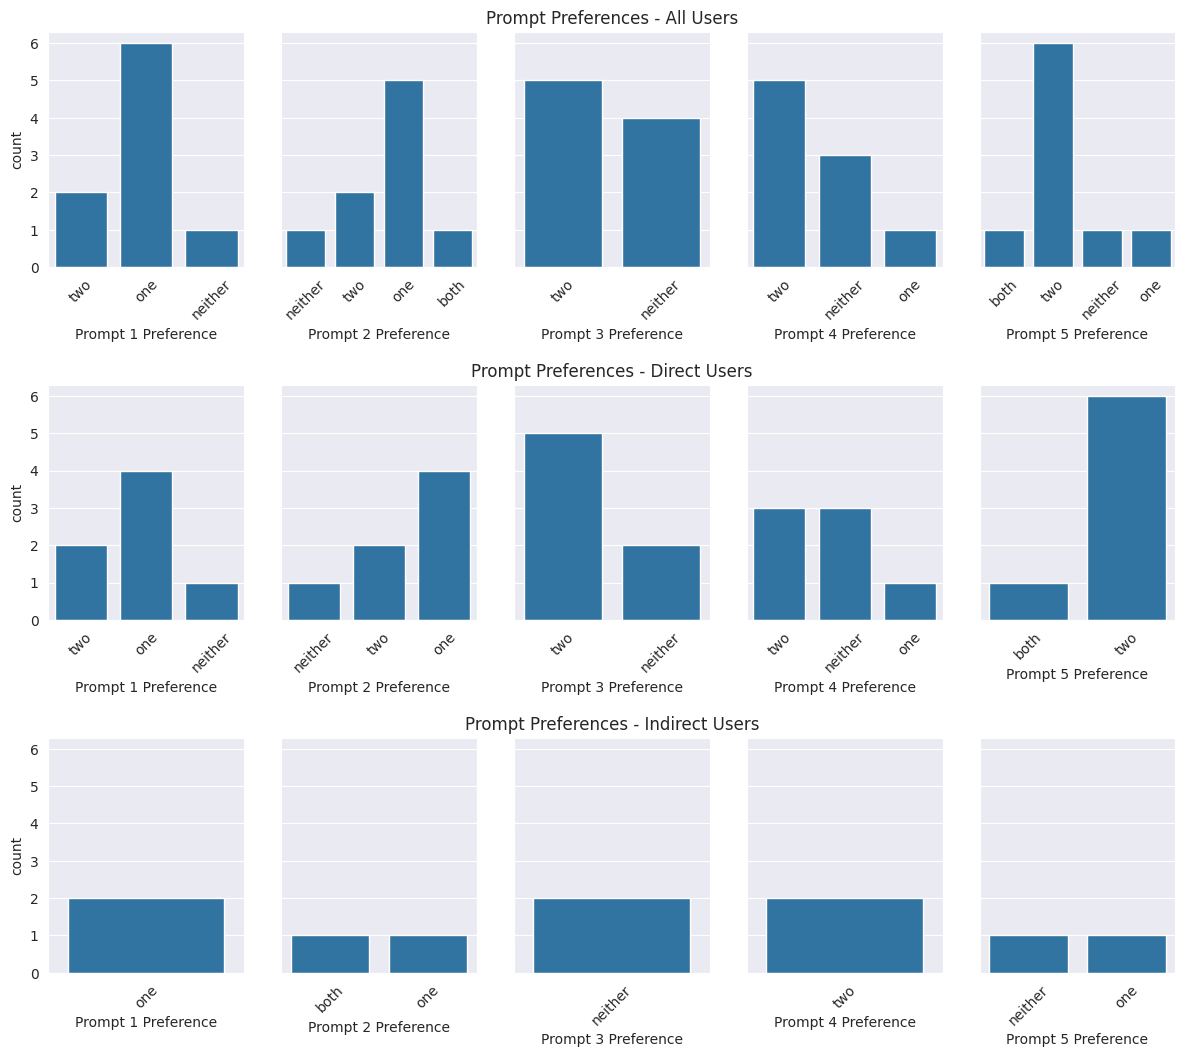

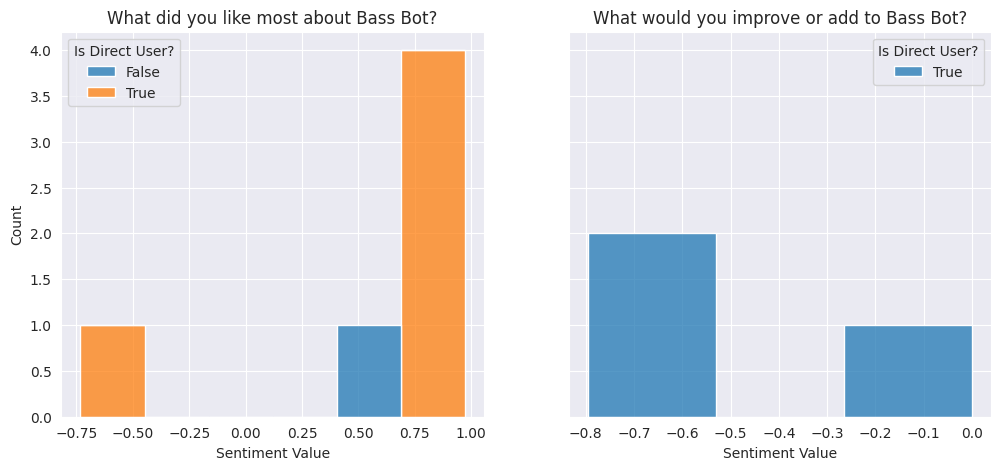

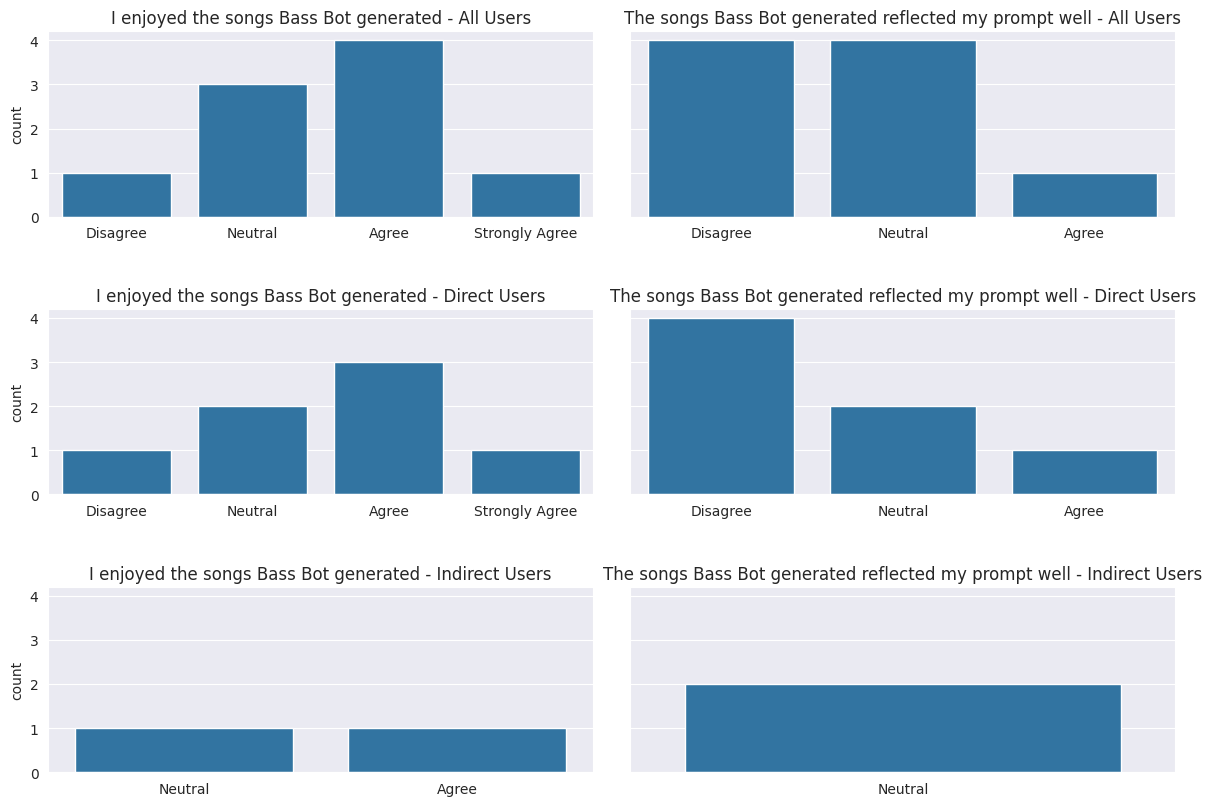

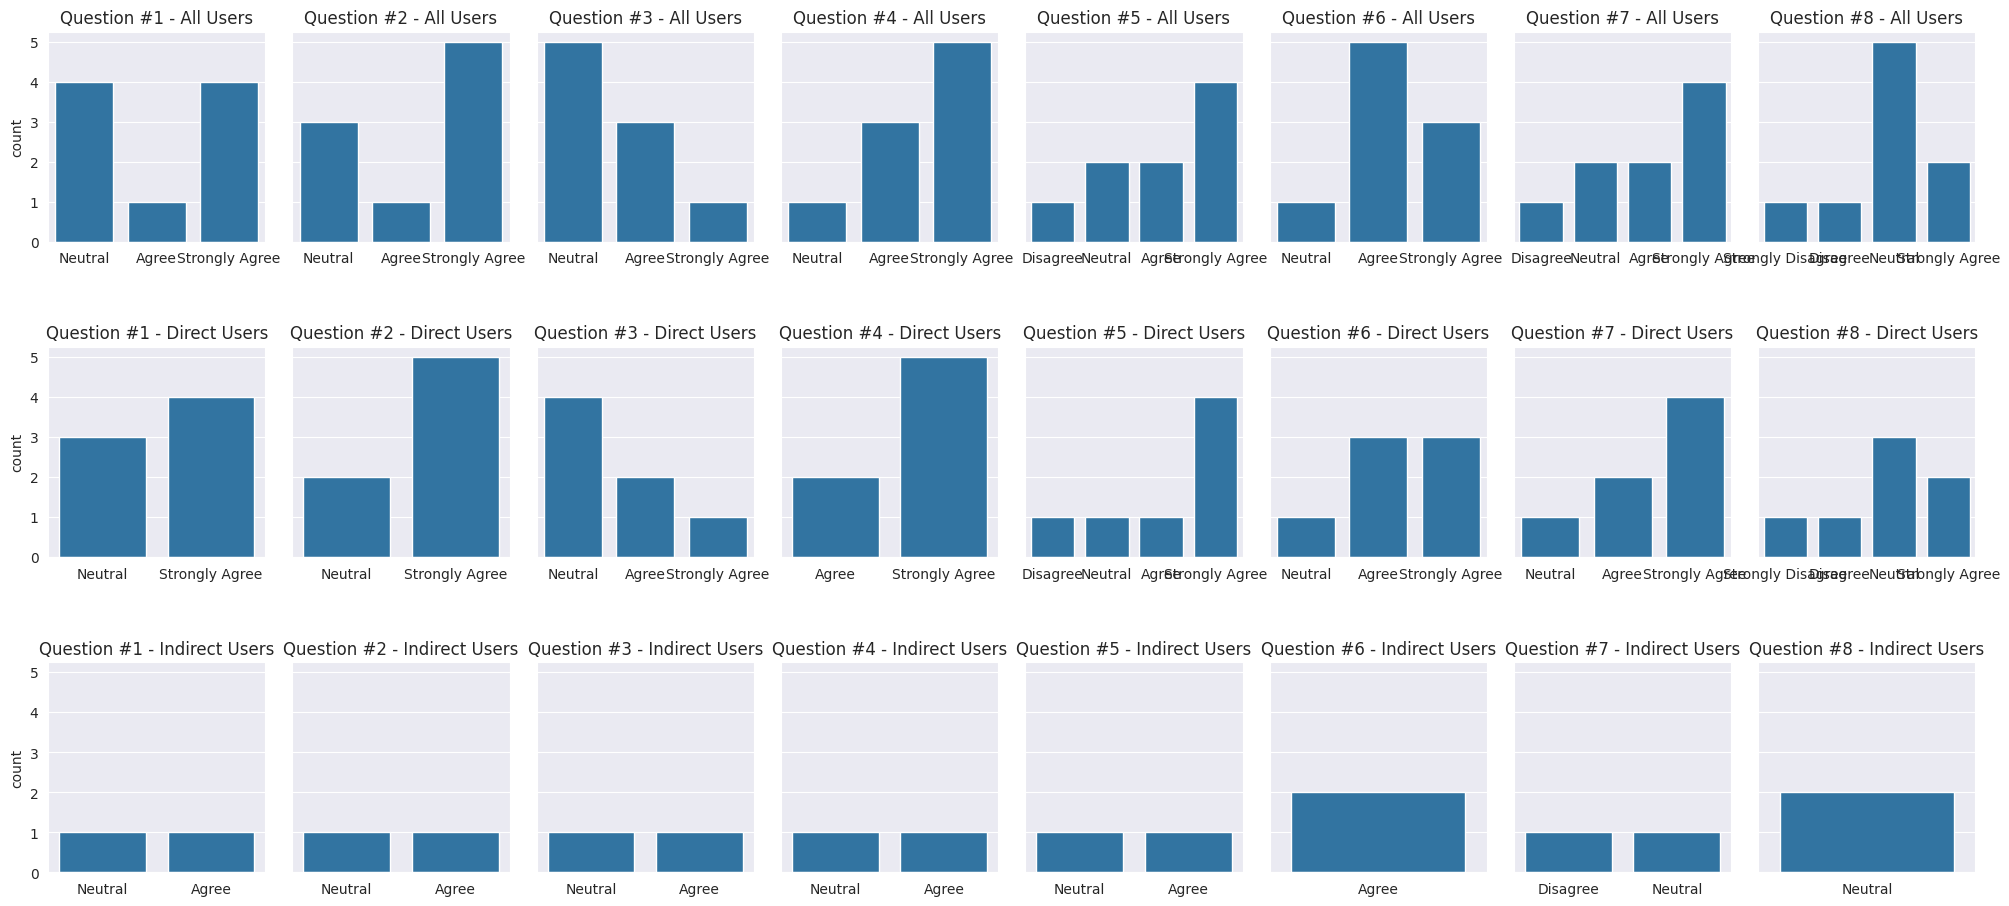

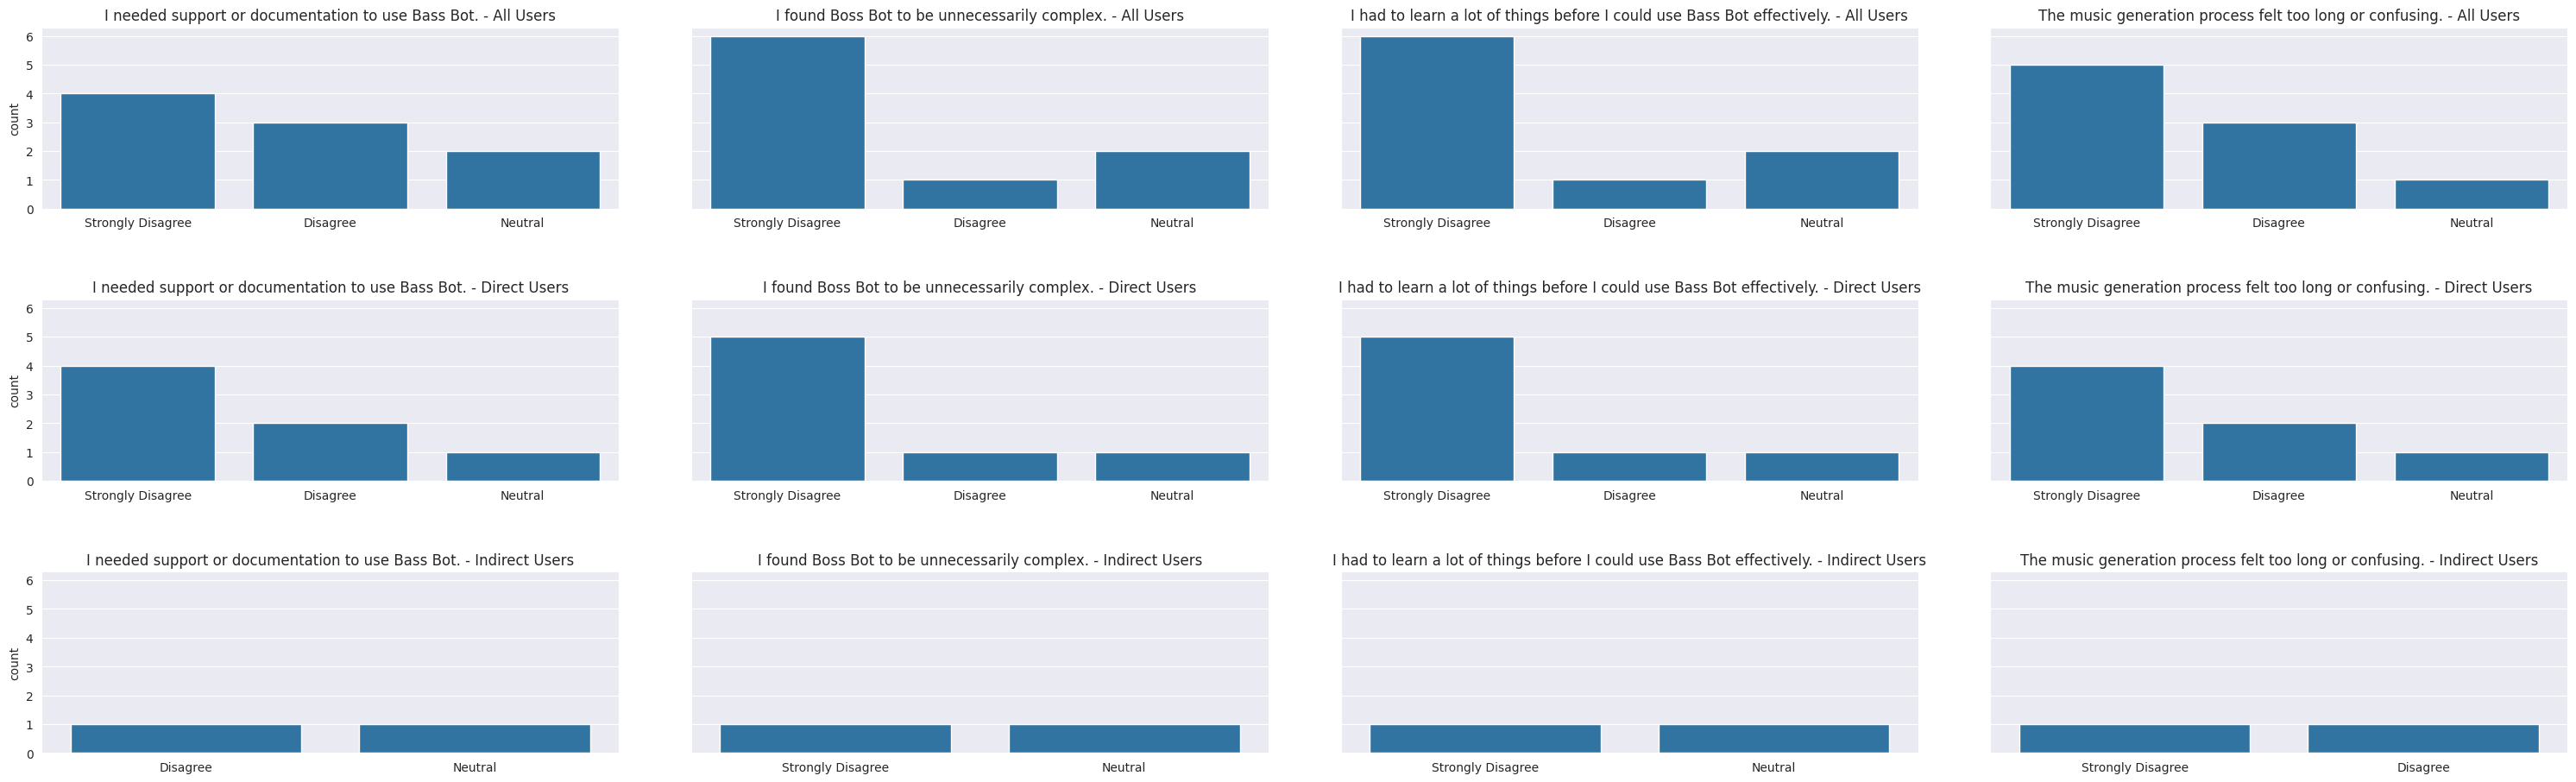

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{prompt_preferences.png}
    \caption{Preferences for Previously Generated Songs ("Neither" is bad)}
    \label{fig-prompt_preferences}
\end{figure}
\\
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{sentiment.png}
    \caption{Sentiment Analysis for Free Response Questions}
    \label{fig-sentiment}
\end{figure}
\\
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{csat_questions.png}
    \caption{Likert Scale Responses for CSAT Questions (Agreement is good)}
    \label{fig-csat_questions}
\end{figure}
\\
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{sus_questions-non-inv.png}
    \caption{Likert Scale Responses for Non-Inverted SUS Questions (Agreement is good)}
    \label{fig-sus_questions-non-inv}
\end{figure}
\\
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{sus_questions-inv.png}
    \caption{Lik

In [9]:
from matplotlib.figure import  Figure
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

plots_dir: Path = data_dir / '..' / 'plots'
plots_dir.mkdir(exist_ok=True, parents=True)

DPI: int = 200

def get_user_df_label(dataframe: pd.DataFrame, row: int) -> tuple[pd.DataFrame, str]:
    match row:
        case 1:
            cdf: pd.DataFrame = dataframe.query('used_server_flag').copy()
            label: str = 'Direct'
        case 2:
            cdf: pd.DataFrame = dataframe.query('not used_server_flag').copy()
            label: str = 'Indirect'
        case _:
            cdf: pd.DataFrame = dataframe.copy()
            label: str = 'All'
    return cdf, label

def plot_preferences(dataframe: pd.DataFrame) -> Path:
    # f, ax = plt.subplots()
    pref_cols: list[str] = [col for col in dataframe.columns if is_prompt_preference_column(col)]

    fig, ax = plt.subplots(3, ncols=len(pref_cols), sharey=True, figsize=(12, 10))
    fig.tight_layout()

    for j in range(3):
        cdf, label = get_user_df_label(dataframe, j)
        for i, col in enumerate(pref_cols):
            cax = sns.countplot(data=cdf, x=col, ax=ax[j][i])
            cax.set_xlabel(f'Prompt {i + 1} Preference')
            cax.set_xticklabels(cax.get_xticklabels(), rotation=45)
            if i == len(pref_cols) // 2:
                cax.set_title(f'Prompt Preferences - {label} Users')
            # plt.title(col.replace('_', ' ').replace(str(i + 1), f' {i + 1}').title())
    fig.subplots_adjust(hspace=0.5)
    save_path: Path = plots_dir / f'prompt_preferences.png'
    fig.savefig(save_path, dpi=DPI)
    return save_path


def plot_sentiment(dataframe: pd.DataFrame) -> Path:
    text_cols: list[str] = [col for col in dataframe.columns if is_text_column(col)]
    # sentiment_columns: list[str] = [get_sentiment_column_name(col) for col in text_cols]
    for col in text_cols:
        dataframe[f'has_text_{col}'] = dataframe[col].str.len() > 0

    f, axs = plt.subplots(1, len(text_cols), sharey=True, figsize=(12, 5))

    for i, col in enumerate(text_cols):
        question: str = column_name_to_question_conversion[col]
        ax: Axes = sns.histplot(data=dataframe.query(f'has_text_{col}').copy(), x=get_sentiment_column_name(col), hue='used_server_flag', ax=axs[i], multiple='stack')
        ax.set_xlabel(f'Sentiment Value')
        ax.get_legend().set_title('Is Direct User?')
        ax.set_title(question)

    save_path: Path = plots_dir / f'sentiment.png'
    f.savefig(save_path, dpi=DPI)
    return save_path

def convert_likert_to_text(col: pd.Series) -> pd.Series:
    return col.sort_values(ascending=True).map({1: 'Strongly Disagree', 2: 'Disagree', 3: 'Neutral', 4: 'Agree', 5: 'Strongly Agree'})

def plot_csat_questions(dataframe: pd.DataFrame) -> Path:
    csat_columns: list[str] = [col for col in dataframe.columns if is_csat_feature_column(col)]

    fig, axs = plt.subplots(3, len(csat_columns), sharey=True, figsize=(12, 8))
    fig.tight_layout()

    for j in range(3):
        cdf, label = get_user_df_label(dataframe, j)
        for i, col in enumerate(csat_columns):
            question: str = column_name_to_question_conversion[col]
            cax: Axes = sns.countplot(x=convert_likert_to_text(cdf[col]), ax=axs[j][i])
            cax.set_title(f'{question} - {label} Users')
            cax.set_xlabel('')
    # fig.suptitle('Customer Satisfaction Scores (CSAT)')
    save_path: Path = plots_dir / 'csat_questions.png'
    fig.subplots_adjust(hspace=0.5)
    fig.savefig(save_path, dpi=DPI)
    return save_path

def plot_non_inv_sus_questions(dataframe: pd.DataFrame) -> Path:
    csat_columns: list[str] = [col for col in dataframe.columns if is_sus_feature_column(col) and not is_inverted_score(col)]

    fig, axs = plt.subplots(3, len(csat_columns), sharey=True, figsize=(20, 9))
    fig.tight_layout()

    for j in range(3):
        cdf, label = get_user_df_label(dataframe, j)
        for i, col in enumerate(csat_columns):
            # question: str = column_name_to_question_conversion[col]
            cax: Axes = sns.countplot(x=convert_likert_to_text(cdf[col]), ax=axs[j][i])
            cax.set_title(f'Question #{i + 1} - {label} Users')
            cax.set_xlabel('')
    # fig.suptitle('System Usability Scores (SUS) - Non-Inverted')
    save_path: Path = plots_dir / 'sus_questions-non-inv.png'
    fig.subplots_adjust(hspace=0.5, wspace=0.125)
    fig.savefig(save_path, dpi=DPI)
    return save_path

def plot_inv_sus_questions(dataframe: pd.DataFrame) -> Path:
    csat_columns: list[str] = [col for col in dataframe.columns if is_sus_feature_column(col) and is_inverted_score(col)]

    fig, axs = plt.subplots(3, len(csat_columns), sharey=True, figsize=(30, 9))
    fig.tight_layout()

    for j in range(3):
        cdf, label = get_user_df_label(dataframe, j)
        for i, col in enumerate(csat_columns):
            question: str = column_name_to_question_conversion[col]
            cax: Axes = sns.countplot(x=convert_likert_to_text(invert_scale(cdf[col], 1, 5)), ax=axs[j][i])
            cax.set_title(f'{question} - {label} Users')
            cax.set_xlabel('')
    # fig.suptitle('System Usability Scores (SUS) - Non-Inverted')
    save_path: Path = plots_dir / 'sus_questions-inv.png'
    fig.subplots_adjust(hspace=0.5, wspace=0.125)
    fig.savefig(save_path, dpi=DPI)
    return save_path

def create_figure_latex(image_path: Path, caption: str, label: str | None = None, width: str = "0.8\\textwidth") -> str:
    """
    Generate LaTeX code for including a graph/image in a figure environment.

    Parameters:
    - image_path: Path to the image file (assumed relative to the LaTeX document).
    - caption: Caption text for the figure.
    - label: Label for referencing the figure in LaTeX.
    - width: Width of the image (LaTeX format, e.g., '0.8\\textwidth').

    Returns:
    - A string of LaTeX code.
    """
    if not isinstance(image_path, Path):
        raise TypeError("image_path must be a pathlib.Path object")

    label: str = label or f'fig-{image_path.stem}'

    return f"""\\begin{{figure}}[h!]
    \\centering
    \\includegraphics[width={width}]{{{image_path.name}}}
    \\caption{{{caption}}}
    \\label{{{label}}}
\\end{{figure}}""".strip()


latex_strings: list[str] = []

latex_strings.append(create_figure_latex(plot_preferences(converted_dataframe), caption='Preferences for Previously Generated Songs ("Neither" is bad)'))
plt.show()
latex_strings.append(create_figure_latex(plot_sentiment(converted_dataframe), caption='Sentiment Analysis for Free Response Questions'))
plt.show()
latex_strings.append(create_figure_latex(plot_csat_questions(converted_dataframe), caption='Likert Scale Responses for CSAT Questions (Agreement is good)'))
plt.show()
latex_strings.append(create_figure_latex(plot_non_inv_sus_questions(converted_dataframe), caption='Likert Scale Responses for Non-Inverted SUS Questions (Agreement is good)'))
plt.show()
latex_strings.append(create_figure_latex(plot_inv_sus_questions(converted_dataframe), caption='Likert Scale Responses for Inverted SUS Questions (Disagreement is good)'))
plt.show()
print('\n\\\\\n'.join(latex_strings))

In [10]:
converted_dataframe[[col for col in converted_dataframe.columns if is_text_column(col)]]

,like_most_text,improve_text
0,That it generated interesting music,
1,,
2,it generally is on theme and having variations...,
3,,
4,Very fun and easy to use.,Honestly the songs could be a bit better
5,"Easy to listen to, funny to listen to with fri...","Longer responses, 30s isn't enough for a ""song..."
6,,
7,Fun,
8,Wide variety of sounds,Sound level differed between prompts


# Validating my functions work

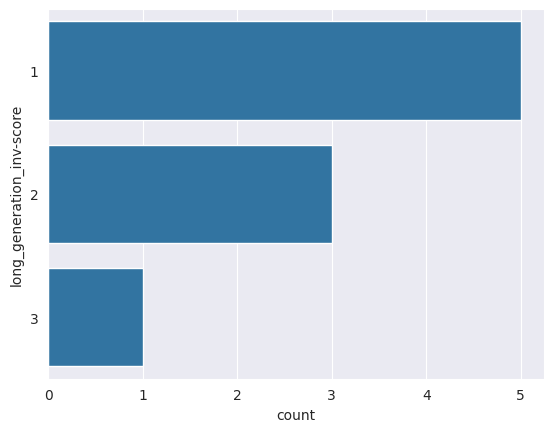

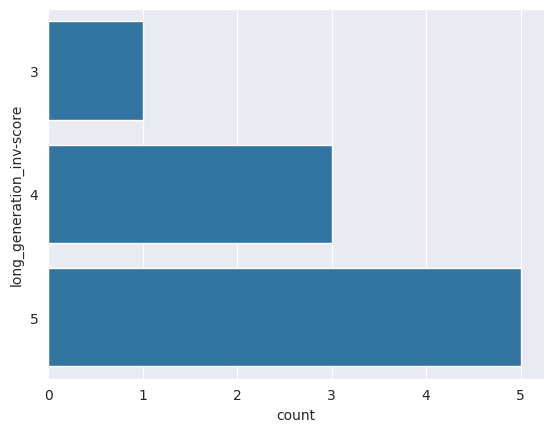

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

conv_df: pd.DataFrame = convert_column_names(df)
orig_col: pd.Series = conv_df['long_generation_inv-score']
inv_col: pd.Series = invert_scale(orig_col, 1, 5)
sns.countplot(y=orig_col)
plt.show()
sns.countplot(y=inv_col)
plt.show()

In [12]:
prompt_cols: list[str] = [col for col in conv_df.columns if col.startswith('prompt') and col.endswith('_preference')]


<Axes: xlabel='prompt1_preference', ylabel='count'>

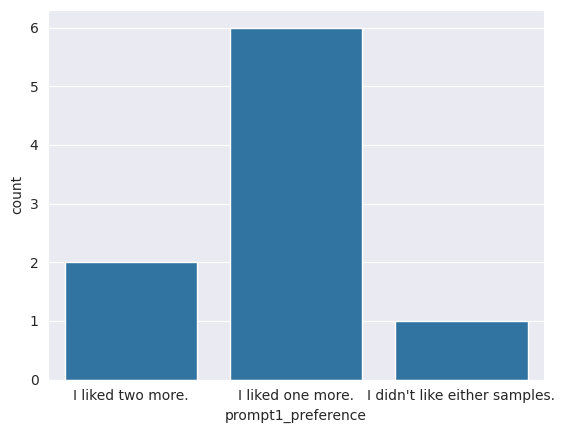

In [13]:
sns.countplot(data=conv_df, x='prompt1_preference')

In [14]:
converted_dataframe

,timestamp,prompt1_preference,prompt2_preference,prompt3_preference,prompt4_preference,prompt5_preference,nps,used_server_flag,enjoyment_songs_score,prompt_reflection_score,...,confidence_score,met_expectations_score,learning_curve_inv-score,intuitive_score,long_generation_inv-score,continued_use_score,like_most_sentiment,improve_sentiment,has_text_like_most_text,has_text_improve_text
0,2025-05-03 18:26:31,two,neither,two,two,both,8,True,5,2,...,3,3,3,3,3,3,0.811237,0.000000,True,False
1,2025-05-03 18:26:48,one,two,two,two,two,1,True,2,4,...,5,5,5,5,5,1,0.000000,0.000000,False,False
2,2025-05-03 18:26:55,two,one,neither,two,two,6,True,3,3,...,4,4,5,5,5,3,0.891163,0.000000,True,False
3,2025-05-03 18:26:55,one,both,neither,two,neither,6,False,3,3,...,4,4,5,2,5,3,0.000000,0.000000,False,False
4,2025-05-03 18:27:01,one,one,two,neither,two,8,True,4,3,...,5,5,5,5,5,5,0.972117,-0.565381,True,True
5,2025-05-03 18:27:14,one,two,two,neither,two,10,True,4,2,...,5,5,5,5,4,5,0.926752,0.000000,True,True
6,2025-05-03 18:27:24,neither,one,two,neither,two,7,True,4,2,...,2,4,4,4,4,2,0.000000,0.000000,False,False
7,2025-05-03 18:27:41,one,one,neither,two,one,5,False,4,3,...,3,4,3,3,4,3,0.581599,0.000000,True,False
8,2025-05-03 18:27:53,one,one,neither,one,two,8,True,3,2,...,5,4,5,4,5,3,-0.732289,-0.795831,True,True
